In [1]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_gray = np.mean(x_train, axis=-1, keepdims=True)
x_test_gray = np.mean(x_test, axis=-1, keepdims=True)

print(f"Train Data Shape: {x_train_gray.shape}, Test Data Shape: {x_test_gray.shape}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Train Data Shape: (50000, 32, 32, 1), Test Data Shape: (10000, 32, 32, 1)


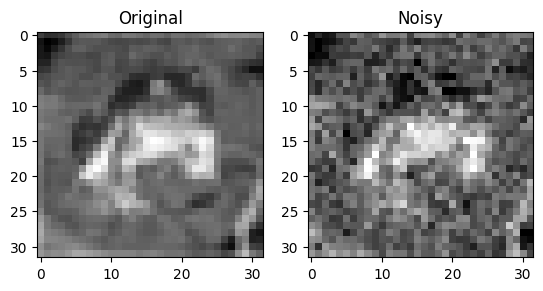

In [2]:

import cv2

def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

def add_salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = np.copy(image)
    total_pixels = image.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]

    noisy_image[salt_coords[0], salt_coords[1], :] = 1
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0
    return noisy_image

x_train_noisy = np.array([add_gaussian_noise(img) for img in x_train_gray])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(x_train_gray[0].squeeze(), cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(x_train_noisy[0].squeeze(), cmap='gray')
axes[1].set_title("Noisy")
plt.show()


### Step 3: Build the Autoencoder Model

In [3]:

input_img = Input(shape=(32, 32, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:

autoencoder.fit(x_train_noisy, x_train_gray, epochs=10, batch_size=128, validation_data=(x_test_gray, x_test_gray))


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0157 - val_loss: 0.0058
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0034 - val_loss: 0.0026


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
PSNR (Original vs Restored): 24.55 dB


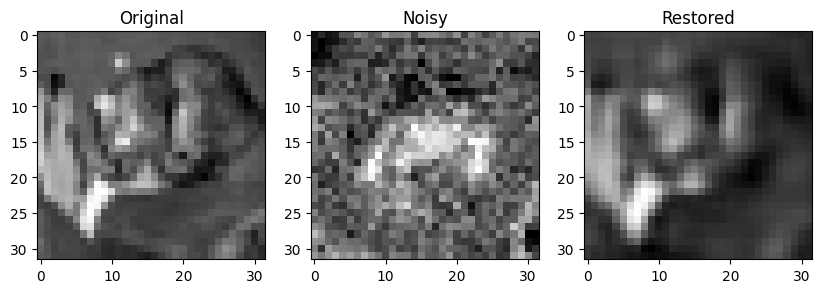

PSNR (Original vs Restored): 24.53 dB


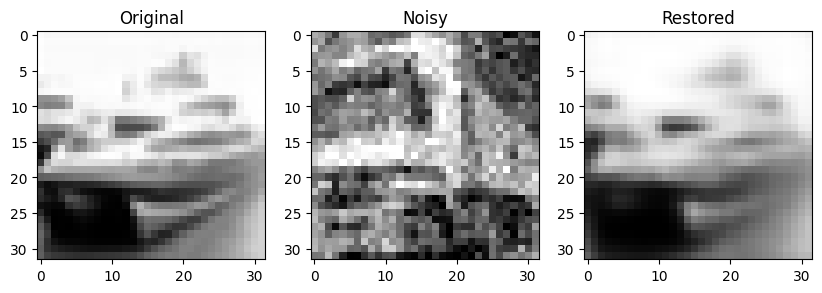

PSNR (Original vs Restored): 25.95 dB


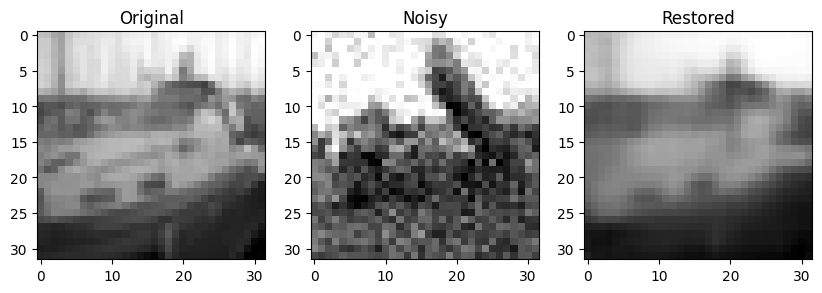

PSNR (Original vs Restored): 26.94 dB


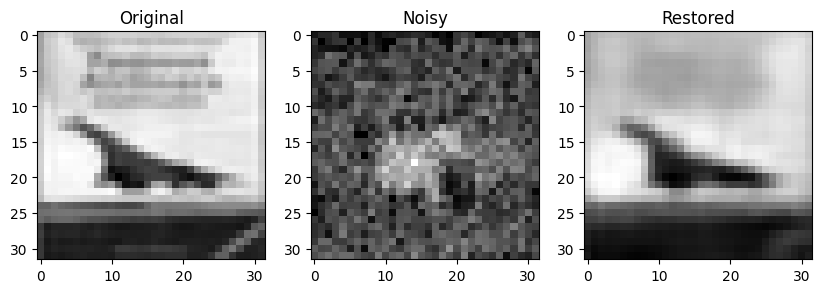

PSNR (Original vs Restored): 24.29 dB


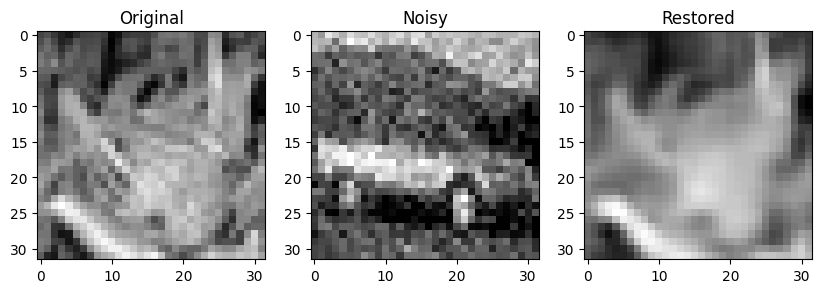

In [5]:

from skimage.metrics import peak_signal_noise_ratio as psnr

restored_images = autoencoder.predict(x_test_gray[:10])

for i in range(5):
    original = x_test_gray[i].squeeze()
    noisy = x_train_noisy[i].squeeze()
    restored = restored_images[i].squeeze()

    print(f"PSNR (Original vs Restored): {psnr(original, restored):.2f} dB")

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title("Original")
    ax[1].imshow(noisy, cmap='gray')
    ax[1].set_title("Noisy")
    ax[2].imshow(restored, cmap='gray')
    ax[2].set_title("Restored")
    plt.show()


In [6]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(100, activation='softmax')(x)

model_vgg16 = Model(inputs=base_model.input, outputs=x)
model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_vgg16.summary()


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,871,716 (56.73 MB)

 Trainable params: 14,871,716 (56.73 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:

history = model_vgg16.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 62ms/step - accuracy: 0.0094 - loss: 4.6124 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 50ms/step - accuracy: 0.0096 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.0087 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.0099 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.0090 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052


In [8]:

import pandas as pd

results = pd.DataFrame({
    "Model": ["VGG16"],
    "Final Accuracy": [history.history["val_accuracy"][-1]],
    "Final Loss": [history.history["val_loss"][-1]]
})

print(results)


   Model  Final Accuracy  Final Loss
0  VGG16            0.01    4.605184


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

alexnet = Sequential([
    Conv2D(96, (11, 11), strides=1, activation='relu', input_shape=(32, 32, 3), padding="same"),
    MaxPooling2D((3, 3), strides=2),

    Conv2D(256, (5, 5), activation='relu', padding="same"),
    MaxPooling2D((3, 3), strides=2),

    Conv2D(384, (3, 3), activation='relu', padding="same"),
    Conv2D(384, (3, 3), activation='relu', padding="same"),
    Conv2D(256, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((3, 3), strides=2),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')  #
])

alexnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

alexnet.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │       9,441,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         409,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,379,492 (115.89 MB)

 Trainable params: 30,379,492 (115.89 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

history_alexnet = alexnet.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_test, y_test)
)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.0089 - loss: 4.6101 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.0087 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.0086 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.0096 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.0095 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052


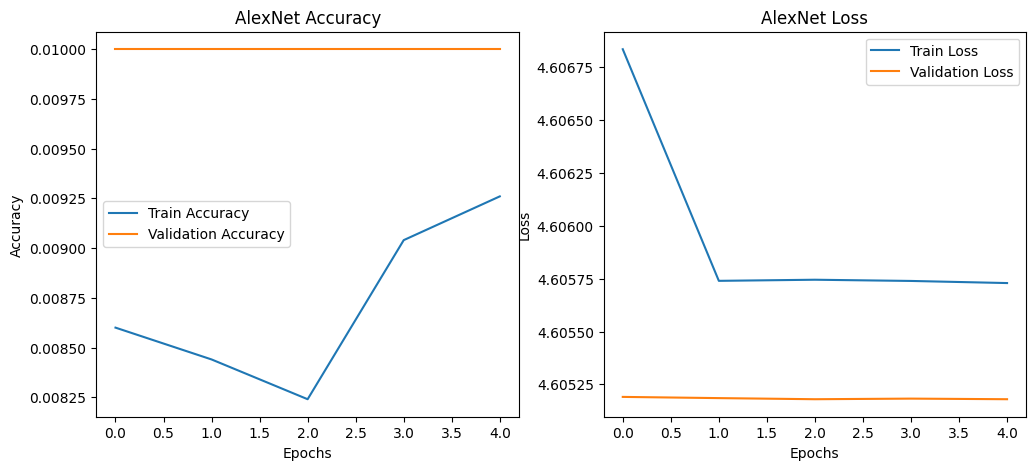

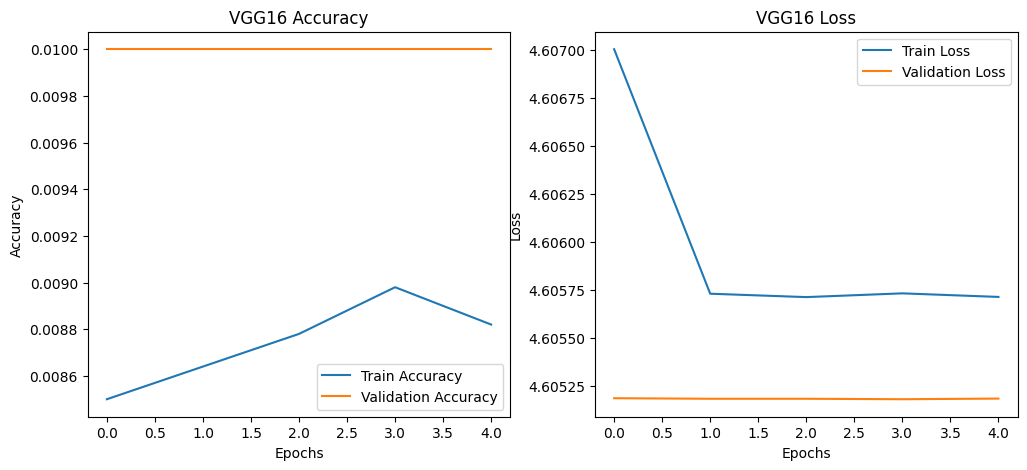

In [12]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history for both models
plot_history(history_alexnet, "AlexNet")
plot_history(history, "VGG16")


In [13]:
import time

# Evaluate AlexNet
start_time = time.time()
alexnet_eval = alexnet.evaluate(x_test, y_test, verbose=0)
alexnet_time = time.time() - start_time

# Evaluate VGG16
start_time = time.time()
vgg16_eval = model_vgg16.evaluate(x_test, y_test, verbose=0)
vgg16_time = time.time() - start_time

# Display Results
print("📌 Model Performance Comparison on CIFAR-100\n")
print(f"🔹 AlexNet  - Accuracy: {alexnet_eval[1]:.4f}, Loss: {alexnet_eval[0]:.4f}, Inference Time: {alexnet_time:.4f} sec")
print(f"🔹 VGG16    - Accuracy: {vgg16_eval[1]:.4f}, Loss: {vgg16_eval[0]:.4f}, Inference Time: {vgg16_time:.4f} sec")


📌 Model Performance Comparison on CIFAR-100

🔹 AlexNet  - Accuracy: 0.0100, Loss: 4.6052, Inference Time: 5.4796 sec
🔹 VGG16    - Accuracy: 0.0100, Loss: 4.6052, Inference Time: 4.2514 sec
